# Summer precipitation anomaly detection using Autoencoder

In [1]:
import xarray as xr
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import cartopy
import cmaps
import proplot as pplt
import cnmaps
from scipy.stats import linregress

from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import load_model
from sklearn.model_selection import train_test_split
from pyimagesearch.convautoencoder import ConvAutoencoder

import os
import pickle
os.environ["KMP_DUPLICATE_LIB_OK"]="TRUE"
os.chdir('/Users/zeqinhuang/Documents/paper/anomalous_PREC')

import warnings
warnings.filterwarnings('ignore')

In [3]:
prec_f = xr.open_dataarray('dataset/china_daily_precipitation_1961_2018.nc')

# calculate precipitation climatological dafrom matplotlib import pyplot as pltily mean
prec_1961_1990 = prec_f.sel(time = slice('1961','1990'))
prec_clim = prec_1961_1990.groupby('time.dayofyear').mean()

# calculate daily precipitation anomalies
prec_ano = prec_f.groupby('time.dayofyear') - prec_clim

# calculate 5-day running-average anomalies to remove the effect of short-term synoptic weather
prec_array = prec_ano.values
prec_array = (prec_array[:-4,:,:] + prec_array[1:-3,:,:] + prec_array[2:-2,:,:] + prec_array[3:-1,:,:] + prec_array[4:,:,:]) / 5
prec_ano[2:-2,:,:] = prec_array

# only select summer time data
prec_ano = prec_ano.sel(time = np.in1d(prec_ano['time.month'], [5,6,7,8,9,10]))
# prec_ano.to_netcdf('dataset/china_daily_precipitation_summer_anomalies_1961_2018.nc')


In [3]:
# create mask for ploting
mask = prec_ano.values[0]
mask[~np.isnan(mask)] = 1

# prec_ano = xr.open_dataarray('dataset/china_daily_precipitation_summer_anomalies_1961_2018.nc')
# prec_mask = prec_ano[0,:,:]
# prec_mask = prec_mask.where(prec_mask.isnull(),1)
# prec_mask = prec_mask.drop_vars(['time','dayofyear'])
# prec_mask.to_netcdf('dataset/China_mainland_mask_05x05.nc')

# Normalzied dataset

In [4]:
# original shape of prec_ano
ano_file = 'dataset/china_daily_precipitation_summer_anomalies_1961_2018.nc'
prec_ano = xr.open_dataarray('dataset/china_daily_precipitation_summer_anomalies_1961_2018.nc')
print(prec_ano.dims,prec_ano.shape)

lons = prec_ano['lon']
lats = prec_ano['lat']

### set miss values as zeros
prec_ano = prec_ano.values
prec_ano = np.nan_to_num(prec_ano, copy=True, nan=0)

### Normalize
print ("data.min()=",prec_ano.min())
print ("data.max()=",prec_ano.max())

minvalue = -20
maxvalue = 150
prec_norm = (prec_ano.squeeze() - minvalue)/(maxvalue - minvalue)
print ("data_norm.min()=",prec_norm.min())
print ("data_norm.max()=",prec_norm.max())
print (np.shape(prec_norm))

('time', 'lat', 'lon') (10672, 70, 123)
data.min()= -18.839333333333332
data.max()= 181.12933333333336
data_norm.min()= 0.006827450980392162
data_norm.max()= 1.1831137254901962
(10672, 70, 123)


In [5]:
# date for training
ts = pd.date_range(start='1961-01-01',end='2018-12-31',freq='D')
ts = ts.strftime('%Y%m%d')
dates = pd.to_datetime(ts, format='%Y%m%d')

# padding for training convinient

In [6]:
padwidth1 = ((0,0),(1,1),(2,3))
prec_norm_img_list = np.pad(prec_norm, pad_width=padwidth1,mode='constant',constant_values=0)
prec_norm_img_list = np.expand_dims(prec_norm_img_list, axis=-1)

time_max, lat_max, lon_max, zmax = np.shape(prec_norm_img_list)
print('Shape of input dataset: ', prec_norm_img_list.shape)

Shape of input dataset:  (10672, 72, 128, 1)


# split training and testing data

In [7]:
train_data, test_data, = train_test_split(prec_norm_img_list, test_size=0.2, random_state=1)
print('Training data shape: ', train_data.shape)
print('Testing data shape: ',test_data.shape)

Training data shape:  (8537, 72, 128, 1)
Testing data shape:  (2135, 72, 128, 1)


# Autoencoder training for train_data

In [8]:
### initialize deep learning parameters
EPOCHS = 10
INIT_LR = 1e-3
BS = 16

In [9]:
### construct convolutional autoencoder
(encoder, decoder, autoencoder) = ConvAutoencoder.build(width=lon_max,height=lat_max,depth=zmax,filters=(32,64,128),latentDim=64)
opt = Adam(lr=INIT_LR,decay=INIT_LR/EPOCHS)
autoencoder.compile(loss='mse',optimizer=opt)

In [10]:
print(autoencoder.summary())

Model: "autoencoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 72, 128, 1)]      0         
                                                                 
 encoder (Functional)        (None, 64)                1273280   
                                                                 
 decoder (Functional)        (None, 72, 128, 1)        1439105   
                                                                 
Total params: 2,712,385
Trainable params: 2,711,489
Non-trainable params: 896
_________________________________________________________________
None


In [11]:
print(encoder.summary())

Model: "encoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 72, 128, 1)]      0         
                                                                 
 conv2d (Conv2D)             (None, 36, 64, 32)        320       
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 36, 64, 32)        0         
                                                                 
 batch_normalization (BatchN  (None, 36, 64, 32)       128       
 ormalization)                                                   
                                                                 
 conv2d_1 (Conv2D)           (None, 18, 32, 64)        18496     
                                                                 
 leaky_re_lu_1 (LeakyReLU)   (None, 18, 32, 64)        0         
                                                           

In [12]:
print(decoder.summary())

Model: "decoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 64)]              0         
                                                                 
 dense_1 (Dense)             (None, 18432)             1198080   
                                                                 
 reshape (Reshape)           (None, 9, 16, 128)        0         
                                                                 
 conv2d_transpose (Conv2DTra  (None, 18, 32, 128)      147584    
 nspose)                                                         
                                                                 
 leaky_re_lu_3 (LeakyReLU)   (None, 18, 32, 128)       0         
                                                                 
 batch_normalization_3 (Batc  (None, 18, 32, 128)      512       
 hNormalization)                                           

## train the convolutional autoencoder

In [13]:
H = autoencoder.fit(
    train_data,train_data,
    validation_data=(test_data,test_data),
    epochs=EPOCHS,
    batch_size=BS
)

Epoch 1/10


2022-12-04 11:33:49.090919: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


534/534 [==============================] - 63s 117ms/step - loss: 0.0147 - val_loss: 0.0083
Epoch 2/10
534/534 [==============================] - 62s 116ms/step - loss: 0.0070 - val_loss: 0.0069
Epoch 3/10
534/534 [==============================] - 56s 105ms/step - loss: 0.0041 - val_loss: 0.0015
Epoch 4/10
534/534 [==============================] - 56s 105ms/step - loss: 3.7258e-04 - val_loss: 1.0153e-04
Epoch 5/10
534/534 [==============================] - 55s 104ms/step - loss: 5.0974e-05 - val_loss: 5.6547e-05
Epoch 6/10
534/534 [==============================] - 56s 104ms/step - loss: 4.3674e-05 - val_loss: 5.0886e-05
Epoch 7/10
534/534 [==============================] - 56s 105ms/step - loss: 3.8090e-05 - val_loss: 3.9182e-05
Epoch 8/10
534/534 [==============================] - 56s 105ms/step - loss: 3.4949e-05 - val_loss: 3.6978e-05
Epoch 9/10
534/534 [==============================] - 56s 104ms/step - loss: 3.2595e-05 - val_loss: 3.2636e-05
Epoch 10/10
534/534 [===============

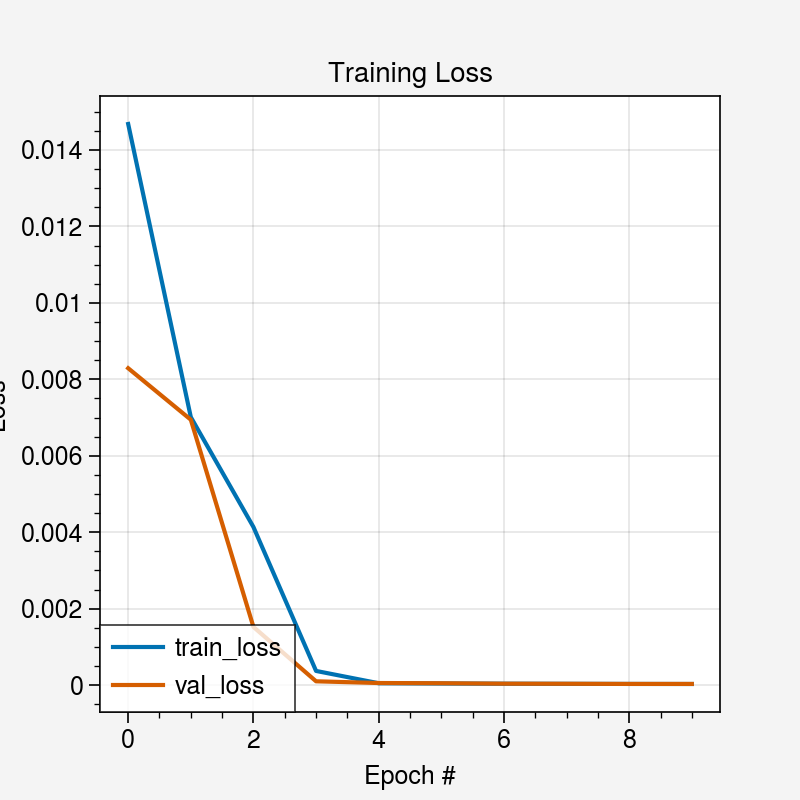

In [14]:
# Loss function plot
N = np.arange(0,10)
plt.plot(N, H.history["loss"], label="train_loss")
plt.plot(N, H.history["val_loss"], label="val_loss")
plt.title("Training Loss")
plt.xlabel("Epoch #")
plt.ylabel("Loss")
plt.legend(loc="lower left")
plt.show()    

# Save trained autoencoder model

In [15]:
autoencoder.save('autoencoder/processed_data/autoencoder_trained.model',save_format='h5')

# Load trained autoencoder model

In [16]:
autoencoder = load_model('autoencoder/processed_data/autoencoder_trained.model')

# Compute error

In [17]:
def comp_error(images, autoencoder):
    time_max,_,_,_ = np.shape(images)
    errors_ = np.zeros(time_max)
    recons_ = autoencoder.predict_on_batch(images)
    for tt in range(time_max):
        errors_[tt] = np.mean((images[tt] - recons_[tt])**2)
    del(recons_)
    return errors_

In [18]:
errors_all = []
for i in range(len(prec_norm_img_list)//100+1):
    if i != len(prec_norm_img_list)//100:
        errors = comp_error(prec_norm_img_list[i*100:i*100+100], autoencoder)
    else:
        errors = comp_error(prec_norm_img_list[i*100:], autoencoder)
    errors_all = errors_all + errors.tolist()

### save error
with open("autoencoder/processed_data/error.pickle", mode="wb") as f:
    pickle.dump(errors_all, f)

In [19]:
## load error
f = open('autoencoder/processed_data/error_summer.pickle', mode="rb")
errors = pickle.load(f)
errors = np.array(errors)

In [20]:
### compute the 95th percentile of the errors as the threshold to identify anomalies
thresh = np.quantile(errors, 0.95)
#thresh = np.quantile(errors, 0.90)
idxs = np.where(np.array(errors) >= thresh)[0]
print("[INFO] mse threshold: {}".format(thresh))
print("[INFO] {} outliers found".format(len(idxs)))

[INFO] mse threshold: 6.24252863908464e-05
[INFO] 534 outliers found


In [21]:
### compute the 90th percentile of the errors as the threshold to identify anomalies
thresh_90th = np.quantile(errors, 0.90)
idxs_90th = np.where(np.array(errors) >= thresh_90th)[0]
print("[INFO] mse threshold: {}".format(thresh_90th))
print("[INFO] {} outliers found".format(len(idxs_90th)))

[INFO] mse threshold: 5.365613442859748e-05
[INFO] 1068 outliers found


# Ploting anomalous precipitation day

In [22]:
def pad_remover(rdata,multidata=False):
    ndim = rdata.ndim
    if ndim==4:
        if multidata:
            recon = rdata[:,1:-1,2:-3,0] # padwidth1 = ((0,0),(1,1),(2,3))
        else:
            recon = rdata[0,1:-1,2:-3,0]
    elif ndim==3:
        recon = rdata[1:-1,2:-3,0]

    return recon

In [23]:
dates_summer = dates[((dates.month > 4) & (dates.month < 11))]

# Time series of observed anomalous days

0.20474330185487094 0.0015479880222103223


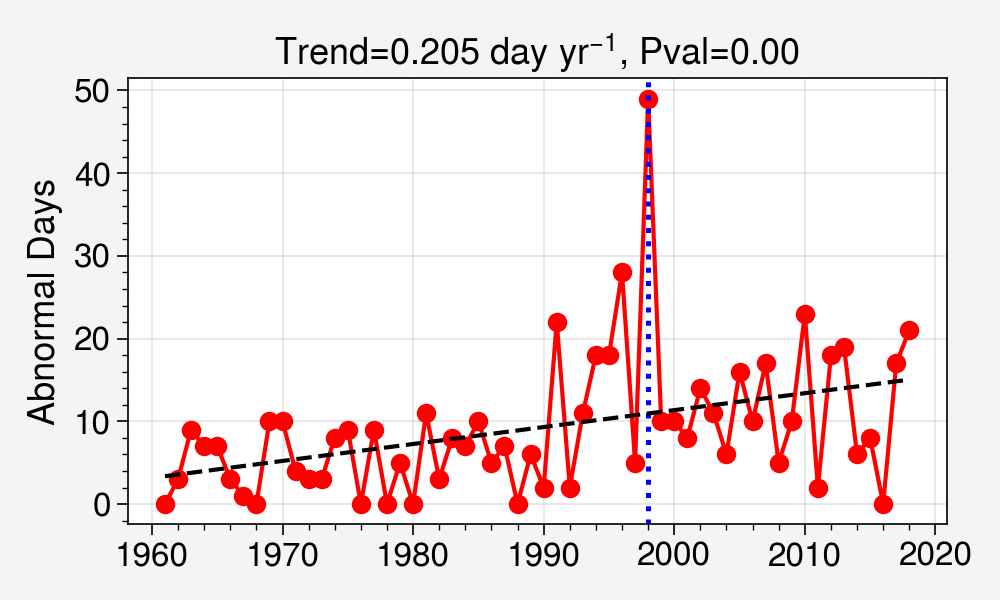

In [28]:
# Time series for anomalous days (using 95th)
ano_dates = dates_summer[idxs]
idxs_pd = pd.Series(idxs)
idxs_pd.index = ano_dates
idxs_pd.to_csv('output/ano_dates_95th.csv')

fig, ax = plt.subplots(figsize=(5,3))

ano_freq = ano_dates.year.value_counts().reindex(dates.year.unique(),fill_value=0).sort_index()
ano_freq.to_csv('output/ano_freq_95th.csv')

# Plot
years = ano_freq.index
# ano_freq = ano_freq['0']
plt.plot(years, ano_freq, "o-", color="r")
plt.axvline(x=1998,color='blue',linewidth=1.8,ls=':')
plt.tick_params(axis='y',colors='black',labelsize = 12)
plt.tick_params(axis='x',colors='black',labelsize = 12)

trend = linregress(years,ano_freq).slope
pval = linregress(years,ano_freq).pvalue
intercept = linregress(years,ano_freq).intercept
print (trend,pval)

if pval <=0.05:
    yy = years * trend + intercept
    plt.plot(years, yy, "--", color="black")
    plt.title("Trend=%.3f day yr$^{-1}$, Pval=%.2f" % (trend,pval),fontdict={'fontsize':13})
else:
    plt.title("Pvalue=%.2f" % (pval))
ax.set_ylabel('Abnormal Days',fontdict={'fontsize':13})

plt.tight_layout()
plt.savefig("figure/abnormal_frequency_time_series.pdf")

0.3430434648866467 0.00012198169402487878


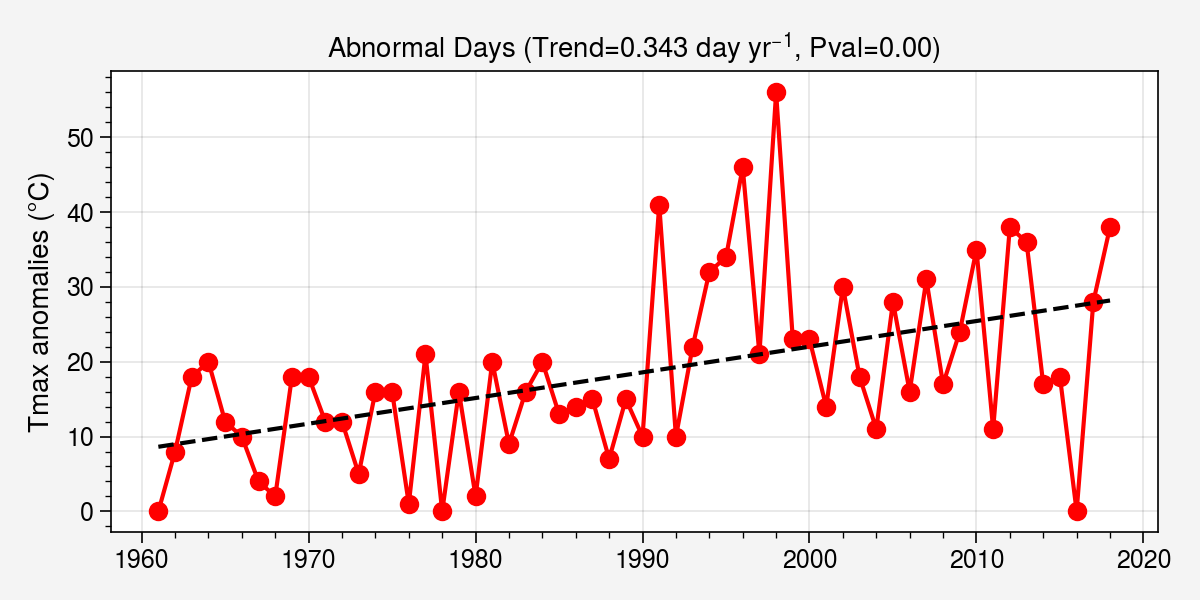

In [29]:
# Time series for anomalous days (using 90th)
ano_dates = dates_summer[idxs_90th]
idxs_pd = pd.Series(idxs_90th)
idxs_pd.index = ano_dates
idxs_pd.to_csv('output/ano_dates_90th.csv')

fig, ax = plt.subplots(figsize=(6,3))

ano_freq = ano_dates.year.value_counts().reindex(dates.year.unique(),fill_value=0).sort_index()
ano_freq.to_csv('output/ano_freq_90th.csv')

# Plot
years = ano_freq.index
ano_freq = ano_freq.to_numpy()
plt.plot(years, ano_freq, "o-", color="r")

trend = linregress(years,ano_freq).slope
pval = linregress(years,ano_freq).pvalue
intercept = linregress(years,ano_freq).intercept
print (trend,pval)

if pval <=0.05:
    yy = years * trend + intercept
    plt.plot(years, yy, "--", color="black")
    plt.title("Abnormal Days (Trend=%.3f day yr$^{-1}$, Pval=%.2f)" % (trend,pval))
else:
    plt.title("Abnormal Days (Pvalue=%.2f)" % (pval))
ax.set_ylabel('Tmax anomalies (°C)',fontdict={'fontsize':10})

plt.tight_layout()
plt.savefig("figure/abnormal_frequency_time_series_90th.pdf")